In [10]:

import yfinance as yf
import pandas as pd

stocks = ["INFY.NS", "TCS.NS", "RELIANCE.NS"]
start_date = "2024-01-01"
end_date = "2025-01-01"

for symbol in stocks:
    print(f"\n📥 Fetching data for {symbol}...")
    
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Skip if no data
    if data.empty:
        print(f"⚠ Skipping {symbol} - No data found")
        continue
    
    # Reset index so 'Date' becomes a column
    data.reset_index(inplace=True)
    
    file_name = f"{symbol}_data.csv"
    data.to_csv(file_name, index=False)
    
    print(f"✅ Saved {file_name} with {len(data)} records and Date column")


C:\Users\palvi\AppData\Local\Temp\ipykernel_21740\3083341957.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\palvi\AppData\Local\Temp\ipykernel_21740\3083341957.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


📥 Fetching data for INFY.NS...
✅ Saved INFY.NS_data.csv with 246 records and Date column

📥 Fetching data for TCS.NS...



C:\Users\palvi\AppData\Local\Temp\ipykernel_21740\3083341957.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


✅ Saved TCS.NS_data.csv with 246 records and Date column

📥 Fetching data for RELIANCE.NS...
✅ Saved RELIANCE.NS_data.csv with 246 records and Date column


In [11]:
import pandas as pd
import glob

csv_files = glob.glob("*.csv")
results = []

for file in csv_files:
    symbol = file.replace("_data.csv", "")
    df = pd.read_csv(file)
    
    # Skip empty CSVs
    if df.empty:
        print(f"⚠ Skipping {symbol} - Empty file")
        continue
    
    # Ensure 'Date' column exists
    if "Date" not in df.columns:
        print(f"⚠ Skipping {symbol} - No Date column")
        continue
    
    # Convert Date to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    
    # Make sure Close is numeric
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    
    # Drop rows with missing Close values
    df.dropna(subset=["Close"], inplace=True)
    
    # Skip if not enough data
    if len(df) < 200:
        print(f"⚠ Skipping {symbol} - Not enough data")
        continue
    
    # Calculate indicators
    df["50_MA"] = df["Close"].rolling(window=50).mean()
    df["200_MA"] = df["Close"].rolling(window=200).mean()
    df["Volatility"] = df["Close"].pct_change().rolling(window=30).std()
    
    avg_volatility = df["Volatility"].mean()
    if avg_volatility < 0.01:
        risk = "Low"
    elif avg_volatility < 0.02:
        risk = "Medium"
    else:
        risk = "High"
    
    short_term_change = None
    if len(df) >= 14:
        short_term_change = (df["Close"].iloc[-1] - df["Close"].iloc[-14]) / df["Close"].iloc[-14] * 100
    
    results.append({
        "Stock": symbol,
        "Risk": risk,
        "ShortTermChange%": round(short_term_change, 2) if short_term_change else None,
        "50_MA": round(df["50_MA"].iloc[-1], 2),
        "200_MA": round(df["200_MA"].iloc[-1], 2)
    })

# Create DataFrame with results
df_results = pd.DataFrame(results)

# Sort & pick recommendations
if not df_results.empty:
    short_term_picks = df_results.sort_values(by="ShortTermChange%", ascending=False).head(10)
    long_term_picks = df_results[df_results["50_MA"] > df_results["200_MA"]].head(10)

    # Save results
    df_results.to_csv("stock_analysis_summary.csv", index=False)
    short_term_picks.to_csv("short_term_picks.csv", index=False)
    long_term_picks.to_csv("long_term_picks.csv", index=False)

    print("\n📈 Short-Term Picks:\n", short_term_picks)
    print("\n🏦 Long-Term Picks:\n", long_term_picks)
else:
    print("⚠ No valid stock data to analyze.")


⚠ Skipping long_term_picks.csv - No Date column
⚠ Skipping short_term_picks.csv - No Date column
⚠ Skipping stock_analysis_summary.csv - No Date column

📈 Short-Term Picks:
          Stock    Risk  ShortTermChange%    50_MA   200_MA
0      INFY.NS  Medium             -4.77  1852.37  1677.59
1  RELIANCE.NS  Medium             -4.91  1285.32  1422.67
2       TCS.NS  Medium             -7.51  4140.93  4048.18

🏦 Long-Term Picks:
      Stock    Risk  ShortTermChange%    50_MA   200_MA
0  INFY.NS  Medium             -4.77  1852.37  1677.59
2   TCS.NS  Medium             -7.51  4140.93  4048.18


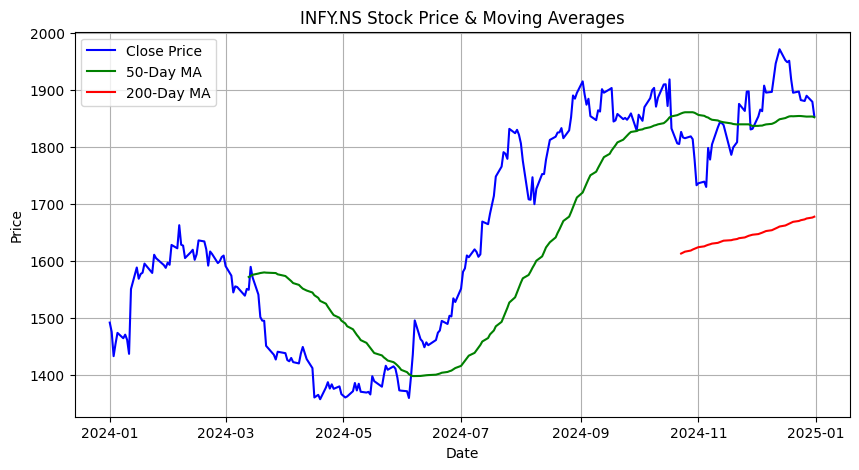

✅ Saved chart: INFY.NS_chart.png


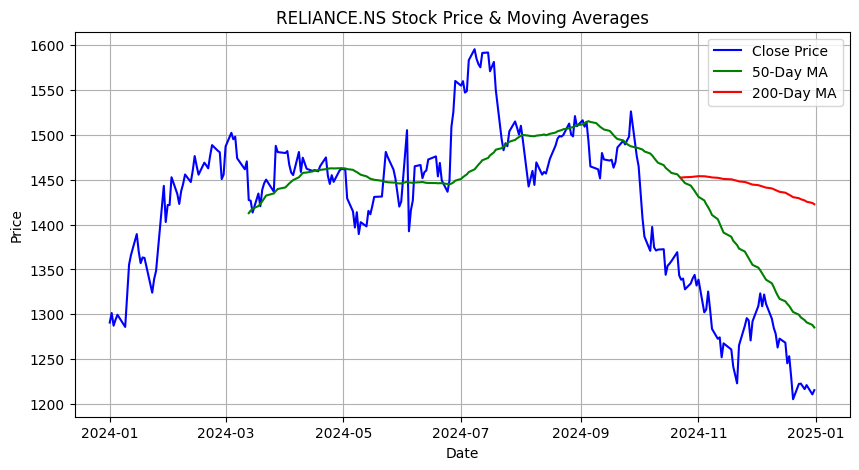

✅ Saved chart: RELIANCE.NS_chart.png


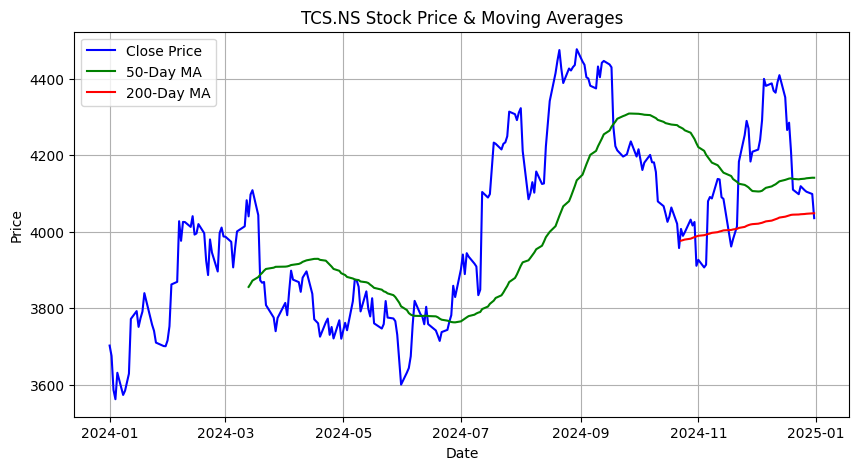

✅ Saved chart: TCS.NS_chart.png


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load recommendations
short_term_picks = pd.read_csv("short_term_picks.csv")
long_term_picks = pd.read_csv("long_term_picks.csv")

# Merge all picks into a unique list
all_picks = pd.concat([short_term_picks, long_term_picks])["Stock"].unique()

for symbol in all_picks:
    file_name = f"{symbol}_data.csv"
    df = pd.read_csv(file_name)
    
    # Ensure Date is datetime
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Convert Close to numeric
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df.dropna(subset=["Close"], inplace=True)
    
    # Calculate moving averages
    df["50_MA"] = df["Close"].rolling(window=50).mean()
    df["200_MA"] = df["Close"].rolling(window=200).mean()
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(df["Date"], df["Close"], label="Close Price", color="blue")
    plt.plot(df["Date"], df["50_MA"], label="50-Day MA", color="green")
    plt.plot(df["Date"], df["200_MA"], label="200-Day MA", color="red")
    
    plt.title(f"{symbol} Stock Price & Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    
    # Save and Show
    image_file = f"{symbol}_chart.png"
    plt.savefig(image_file, dpi=300)
    plt.show()  # This will display inside the notebook
    
    print(f"✅ Saved chart: {image_file}")


In [6]:
from fpdf import FPDF
import pandas as pd
import os

# Load tables
short_term_picks = pd.read_csv("short_term_picks.csv")
long_term_picks = pd.read_csv("long_term_picks.csv")

# Create PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# ===== Cover Page =====
pdf.add_page()
pdf.set_font("Arial", 'B', 20)
pdf.cell(0, 10, "Stock Analysis & Recommendation Report", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", size=14)
pdf.cell(0, 10, "Prepared by: Your Name", ln=True, align='C')

# ===== Short-Term Picks Table =====
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Short-Term Stock Picks", ln=True)

pdf.set_font("Arial", size=12)
for i, row in short_term_picks.iterrows():
    pdf.cell(0, 8, f"{row['Stock']} | Risk: {row['Risk']} | Change: {row['ShortTermChange%']}% | 50MA: {row['50_MA']} | 200MA: {row['200_MA']}", ln=True)

# ===== Long-Term Picks Table =====
pdf.ln(5)
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Long-Term Stock Picks", ln=True)

pdf.set_font("Arial", size=12)
for i, row in long_term_picks.iterrows():
    pdf.cell(0, 8, f"{row['Stock']} | Risk: {row['Risk']} | Change: {row['ShortTermChange%']}% | 50MA: {row['50_MA']} | 200MA: {row['200_MA']}", ln=True)

# ===== Stock Charts =====
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Stock Price Charts", ln=True)

charts = [f for f in os.listdir() if f.endswith("_chart.png")]
for chart in charts:
    pdf.add_page()
    pdf.image(chart, x=10, y=20, w=180)  # Adjust size to fit page
    pdf.ln(85)

# ===== Save PDF =====
pdf.output("stock_report.pdf")
print("✅ PDF report saved as stock_report.pdf")


✅ PDF report saved as stock_report.pdf
